<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/12_TheDawnOfTransformers/SpacialTransformers/SpacialTransformers_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Transformers

The spatial transformer module consists of layers of neural networks that can spatially transform an image. These spatial transformations include cropping, scaling, rotations, and translations etc

The architecture of a Spatial Transformer Network is based on three important parts.

- The localization network.
- Grid generator.
- Sampler.

![image](https://user-images.githubusercontent.com/42609155/127073287-08c80ce8-9686-4bdc-9933-cc6801f0f3cb.png)

The PyTorch tutorials have a [Spatial Transformer Networks](https://brsoff.github.io/tutorials/intermediate/spatial_transformer_tutorial.html) Tutorial which uses the digit MNIST dataset. But we will work with the CIFAR10 dataset. 

## Import necessary libraries

In [1]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

## Calculate mean and std for CIFAR dataset

In [2]:
def calculate_mean_std(dataset):
    if dataset == 'CIFAR10':
        train_transform = transforms.Compose([transforms.ToTensor()])
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        mean = train_set.data.mean(axis=(0,1,2))/255
        std = train_set.data.std(axis=(0,1,2))/255
        return mean, std
mean,std = calculate_mean_std('CIFAR10')

Files already downloaded and verified


In [3]:
mean,std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

## Download and prepare CIFAR10 dataset

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091),(0.24703223, 0.24348513, 0.26158784))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2434, 0.2615))
    ])), batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model Architecture

- Firstly, we define a simple convolutional classifier network to classify the CIFAR10 dataset images
- Then, we have the Localization Network (self.localization) of the Spatial Transformer Network. Here we have a 2D convolutional layer with 3 input channels as the CIFAR10 datasets images are colored with three channels (RGB). It is followed by max-pooling and ReLU activation. Then we have another set of Conv->Maxpool->ReLu.
- Now to regress the transformation parameters θ, we need fully connected linear layers. This is exactly what the self.fc_loc module does.The first linear layer’s input features are 128*4*4. This is something that we have to get through the self.localization module’s last layer’s output.
- We then initialize the self.fc_loc module’s last linear layer weight and biases. We initialize them with identity transformations.
- Next, we have the stn() function. Here, 
  - we get the feature maps using the self.localization module. 
  - Then we resize them and pass them onto the self.fc_loc module to get the transformation parameters theta.
  - we generate the parameterized sampling grid using the affine_grid() function. 
  - Finally, we apply the spatial transformations and return the transformed feature maps.
- Finally, we have the forward() function. 
  - First, we execute the stn() function to get the transformed inputs. 
  - Then, we perform a simple forward pass through the classification network using these transformed feature maps.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(32*5*5, 1024)
        self.fc2 = nn.Linear(1024, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, xs.size(1) * xs.size(2) * xs.size(3))
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [6]:
# initialize the model
model = Net().to(device)

# initialize the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=800, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=6, bias=True)
  )
)


## Training and Validation

Now, let’s use the SGD algorithm to train the model. The network is learning the classification task in a supervised way. In the same time the model is learning STN automatically in an end-to-end fashion.

In [9]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## Visualizing the STN Results

In [10]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.49139968, 0.48215841, 0.44653091])
    std = np.array([0.24703223, 0.24348513, 0.26158784])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(20,15))
        # f = plt.figure(figsize=(20,15))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 51):
    train(epoch)
    test()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.323545
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.059350


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.8503, Accuracy: 3455/10000 (35%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.831888
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.886865

Test set: Average loss: 1.6227, Accuracy: 4204/10000 (42%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.694754
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.606473

Test set: Average loss: 1.5204, Accuracy: 4549/10000 (45%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.796990
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.633417

Test set: Average loss: 1.4311, Accuracy: 4865/10000 (49%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.567344
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.531219

Test set: Average loss: 1.3916, Accuracy: 4944/10000 (49%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.736797
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.657320

Test set: Average loss: 1.3568, Accuracy: 5155/10000 (52%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.481957
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.382086

Test set: Average loss: 1.3456, Accuracy: 5275/10000 (53%)

Tra

By the end of 50 epoch, we have training accuracy of 64% and validation accuracy of 67%. The training loss is 0.642411 and validation loss 0.9894. The results are not too good. Still let’s see how well our model has spatially transformed the images.

## Visualizing the Spatial Transformations by the STN Model


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

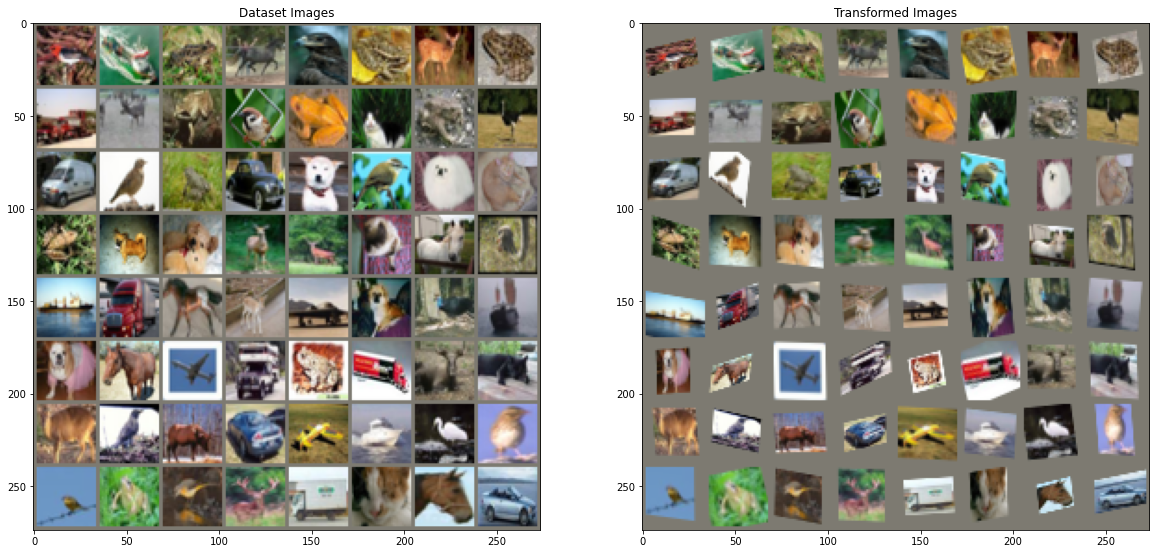

In [11]:

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

The spatial transformations here are very prominent. Our Spatial Transformer Network model has cropped and resized most of the images to the center. It has rotated many of the images to an orientation that it feels will be helpful. Although some of the orientations are not centered. Maybe a bit of more training will help.